## Demonstration of registration and cropping with SimpleITK

This notebook demonstrates a possible approach to obtaining the region around the chest in mouse x-rays. Note that the registration approach taken here is one of a number of possible approaches. Other approaches include geometric alignment using PCA, template matching and object detection e.g. using YOLO for Faster R-CNN. See the [SimpleITK registration documentation](https://simpleitk.readthedocs.io/en/v1.1.0/Documentation/docs/source/registrationOverview.html) for more information about image registration using SimpleITK.

### Plan
1. Manually rotate an image to the required orientation (I did this with ImageJ). This is the reference image.
2. Manually define the region of interest (ROI) in the reference image.
3. Given a new image, align it to the same orientation as the reference image using rigid body registration
4. Crop the aligned image using the ROI defined in the reference image

### Requirements
1. [SimpleITK](https://simpleitk.readthedocs.io/en/master/)
2. [Matplotlib](https://matplotlib.org/)
3. [Numpy](https://numpy.org/)

In [1]:
# Import the dependencies
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import SimpleITK as sitk

The cell below defines utility functions. These were taken from the [SimpleITK examples](http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/60_Registration_Introduction.html) and  modified for 2D images.

In [2]:
# Utitily functions for simpleITK registration

from ipywidgets import interact, fixed
from IPython.display import clear_output

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
#def display_images_with_alpha(image_z, alpha, fixed, moving):
#    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
#    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
#    plt.axis('off')
#    plt.show()

# 2D image version
def display_images_with_alpha(alpha, fixed, moving):
    img = (1.0 - alpha)*fixed + alpha*moving 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

### Main registration function
The cell below contains the main regsitration function. Again this was modified from the [SimpleITK registration notebooks](http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/60_Registration_Introduction.html) .

In [3]:
# This is the registration configuration which we use in all cases. The only parameter that we vary 
# is the initial_transform. 
def multires_registration(fixed_image, moving_image, initial_transform):
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    # SimpleITK example was sampling at 0.01 - increased this to get more reliable registration
    registration_method.SetMetricSamplingPercentage(0.1)
    registration_method.SetInterpolator(sitk.sitkLinear)
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, estimateLearningRate=registration_method.Once)
    registration_method.SetOptimizerScalesFromPhysicalShift() 
    registration_method.SetInitialTransform(initial_transform, inPlace=False)
    # Use 4 pyramid levels (instead of 3 as in the SimpleITK examples)
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [8,4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas = [4,2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    final_transform = registration_method.Execute(fixed_image, moving_image)
    print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
    print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
    return (final_transform, registration_method.GetMetricValue())

The cell below contains two utility functions I wrote. The first was necessary, because the DICOM images had a third dimension of 1-plane which is redundant and made SimpleITK think they were 3D images instead of 2D images. The third dimension is 'squeezed'. Also add a function to plot rectangles to ease showing ROIs on images

In [4]:
def squeeze_image(im):
    """Squeeze third dimension of sitk images (size 1) so they are 2D images
    
    """
    im_numpy = sitk.GetArrayFromImage(im)
    im_sitk = sitk.GetImageFromArray(np.squeeze(im_numpy))
    return im_sitk

def plot_rect(left, top, width, height, ax=None):
    
    right = left + width
    bottom = top + height
    x = [left, left,   right,  right, left]
    y = [top,  bottom, bottom, top,   top]
    if ax == None:
        ax = plt.gca()
    ax.plot(x, y, 'r')

In [5]:
# Registration attempt using SimpleITK 
# http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/60_Registration_Introduction.html
import SimpleITK as sitk

# Read in the reference image. Assumed to be in the same dir as this notebook
fixed_image = sitk.ReadImage("reference_image.png", sitk.sitkFloat32)

# Read in the image to be aligned
# You need to provide your own image - see https://www.ebi.ac.uk/~kola/383185.dcm if you need to download one
moving_image = squeeze_image(sitk.ReadImage("383185.dcm", sitk.sitkFloat32))

# Initially align the centers
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler2DTransform())

final_transform,_ = multires_registration(fixed_image, moving_image, initial_transform)

# Apply the transform to get the aligned version of the image to be aligned
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

Final metric value: -0.40004556807809516
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 69.


In [6]:
# Interactively view aligned images
interact(display_images_with_alpha, alpha=0.5, fixed = fixed(fixed_image), moving=fixed(moving_resampled));

interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.5, min=-0.5), Output()), _dom_classes=…

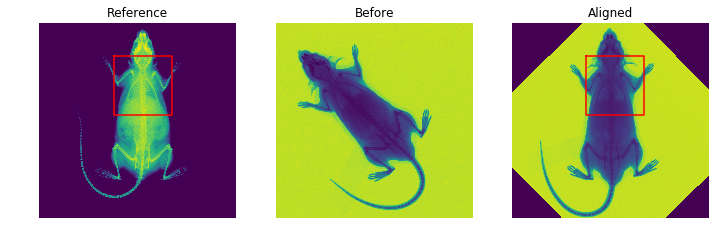

In [7]:
# ROI parameters
left = 890
top = 400
width = 700
height = width

# Plot the reference and aligned images and overlay ROI
plt.figure(figsize=(12,10))

ax = plt.subplot(1,3,1)
plt.imshow(sitk.GetArrayViewFromImage(fixed_image))
plot_rect(left, top, width, height)
ax.set_title('Reference')
plt.axis('off')

ax = plt.subplot(1,3,2)
plt.imshow(sitk.GetArrayViewFromImage(moving_image))
plt.axis('off')
ax.set_title('Before')

ax = plt.subplot(1,3,3)
plt.imshow(sitk.GetArrayViewFromImage(moving_resampled))
plot_rect(left, top, width, height)
plt.axis('off')
ax.set_title('Aligned');


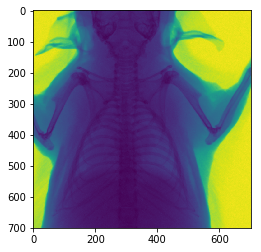

In [8]:
# Display cropped image
moving_resampled_np = sitk.GetArrayFromImage(moving_resampled)
cropped_image = moving_resampled_np[top:top+height+1, left:left+width+1]
plt.imshow(cropped_image);